In [ ]:
import sys

sys.path.append('./source/')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy import interpolate as intp
import importlib
import healpy

from source import plots
from source import prob_dists as pd
from utils import read_param_file, update_params

In [3]:
param_file = './source/n0.params'
params = read_param_file(param_file)
p = params

exposure = 5 * 14000 / (4 * np.pi)
p = update_params(param_file, p, 'exposure', exposure)

phipp = 7.12073e-30
fwimp = phipp * 8 * np.pi / 1e-28
# fwimp = 1e-4
p = update_params(param_file, p, 'fwimp', fwimp)

p = update_params(param_file, p, 'bg', 1)
p = update_params(param_file, p, 'beg', 1)

print(exposure, fwimp)
p

5570.423008216337 1.7896346444957159


{'R_G': 220,
 'd_solar': 8.5,
 'psi': 40,
 'M_min': 0.01,
 'M_max': 10000000000.0,
 'fwimp': 1.7896346444957159,
 'mean_params': {'a': 77.4, 'b': 0.87, 'c': -0.23},
 'nside': 128,
 'area_fermi': 2000.0,
 'n': 0,
 'log_flux_min': -15,
 'log_flux_max': -5,
 'N': 1000,
 'log_k_min': -3,
 'log_k_max': 6,
 'N_k': 250000,
 'psh_log_f_min': -7,
 'psh_log_f_max': -2.5,
 'N_psh': 1000,
 'omega_pixel': 6.391586616190171e-05,
 'exposure': 5570.423008216337,
 'iso_flux_bg': 0.0008939106670451649,
 'gal_flux_bg_file': './output/gal_flux_bg.npy',
 'bg': 1,
 'beg': 1}

In [4]:
nside = p['nside']
npix = healpy.nside2npix(nside)
lon, lat = healpy.pix2ang(nside, range(npix), lonlat=True)
ang_dists = np.rad2deg(np.arccos(np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))))
good_indices = (abs(lat) >= 40)

less than zero 0
(196608,) (100, 70144)
[]


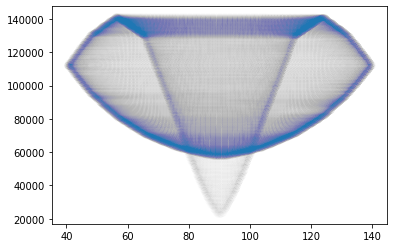

In [5]:
## S-WAVE
s_psh, s_pshfunc2d, s_fluxes, _ = pd.psh_s(ang_dists[good_indices], return_all=True)
# s_psh /= np.trapz(s_psh, s_fluxes, axis=0)

print('less than zero', np.sum(s_psh < 0))
s_counts = np.arange(0, 500)
print(ang_dists.shape, s_psh.shape)
print(s_psh[s_psh < 0])
plt.scatter(ang_dists[good_indices], s_psh[40], alpha=0.005)

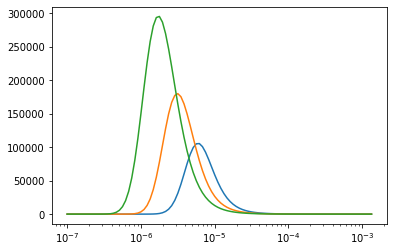

In [6]:
for i in [4000, 24000, 57000]:
    plt.plot(s_fluxes, s_psh[:, i])
plt.xscale('log')

less than zero 0


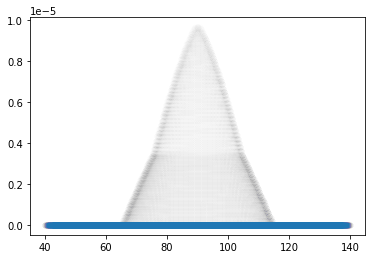

In [7]:
## SOM
som_psh, som_pshfunc2d, som_fluxes, _= pd.psh_som(ang_dists[good_indices], return_all=True)
print('less than zero', np.sum(s_psh < 0))
som_counts = np.arange(0, 2000)
plt.scatter(ang_dists[good_indices], som_psh[0], alpha=0.005)

In [8]:
# backgrounds
gal_bg = np.load(p['gal_flux_bg_file'])[good_indices] * p['exposure']
iso_bg = p['iso_flux_bg'] * p['exposure']
bg_count = gal_bg + iso_bg

In [9]:
# pc for generating skymaps
s_pc_of_psi = pd.pc_of_psi(p, s_pshfunc2d, s_fluxes, s_counts)
som_pc_of_psi = pd.pc_of_psi(p, som_pshfunc2d, som_fluxes, som_counts)

# choose between s and som
pc_of_psi = s_pc_of_psi 

background = True 



largest count is 65.0 ...this may take a while


In [10]:
# search parameters
num_search = 25
p['fwimp'] *= 1

fwimps = np.logspace(np.log10(p['fwimp'])-1, np.log10(p['fwimp'])+1, num_search)
begs = np.linspace(.9, 1.1, num=9)
# fwimps = np.logspace(np.log10(p['fwimp'])-0.5, np.log10(p['fwimp'])+0.5, num_search)

exposure_search = np.logspace(0, 1, num=3) * p['exposure']
# exposure_search = np.array([5]) * p['exposure']

In [11]:
 def likelihood_run_for_model(pshfunc2d, counts, psh, fluxes, poisson_rescale=1, model=''):
    # run likelihoods
    s_S = np.zeros((len(exposure_search), num_search))
    som_S = np.zeros((len(exposure_search), num_search))
    poisson_S = np.zeros((len(exposure_search), num_search))

    total, mean, std, meanpc = [], [], [], []
    for i, exposure in enumerate(exposure_search):
        p['exposure'] = exposure

        gal_bg = np.load(p['gal_flux_bg_file'])[good_indices] * p['exposure'] * p['bg']
        iso_bg = p['iso_flux_bg'] * p['exposure'] * p['beg']
        bg_count = gal_bg + iso_bg

        # make the simulated skymap
#         psis = np.linspace(40, 180, num=500)
        
#         bg_count = np.array([0])
        counts = np.arange(0, bg_count.max() + p['exposure'] * p['fwimp'] * fluxes.max() + 9 * np.sqrt(p['exposure'] * p['fwimp'] * fluxes.max()))
#         counts = np.arange(100)

        print('calculating pc to count =', counts[-1])
    
        unique_ang, uni_ind, uni_inv = np.unique(np.abs(ang_dists[good_indices]), return_inverse=True, return_index=True)

        pshdat = psh[:, uni_ind]
        psh = pshdat[:, uni_inv]
        if model == 's':
            spsh = pshdat[:, uni_inv]
            sompsh = som_psh
        elif model == 'som':
            sompsh = pshdat[:, uni_inv]
            spsh = s_psh
#         pshdat = pshfunc2d(unique_ang, fluxes)
# #         pshdat /= np.trapz(pshdat, fluxes, axis=0)[np.newaxis, :]
#         pshdat /= integrate.simps(pshdat, fluxes, axis=0)[np.newaxis, :]
#         print(integrate.simps(pshdat, fluxes, axis=0))
#         pshdat = pshfunc2d(ang_dists[good_indices], fluxes)
#         pshdat /= np.trapz(pshdat, fluxes, axis=0)[np.newaxis, :]

#         pc_psi = np.trapz(pshdat[:, :, np.newaxis] * stats.poisson.pmf(counts[np.newaxis, np.newaxis, :], p['exposure'] * p['fwimp'] * fluxes[:, np.newaxis, np.newaxis]), fluxes, axis=0)
        pc_psi = integrate.simps(pshdat[..., np.newaxis] * stats.poisson.pmf(counts[np.newaxis, np.newaxis, :], p['exposure'] * p['fwimp'] * fluxes[:, np.newaxis, np.newaxis]), fluxes, axis=0)

#         print('bad pc norm for generating data:', np.sum(np.abs(np.sum(pc_psi, axis=-1)-1) > 1e-10))
        pc_psi /= np.sum(pc_psi, axis=-1)[:, np.newaxis]
        
#         print(pc_psi.shape, np.sum(pc_psi, axis=-1))
        print('is pc norm', np.allclose(np.sum(pc_psi, axis=-1), 1))
        print('last pc prob', pc_psi[:, -1])

        pc_of_psi = pc_psi[uni_inv]
#         pc_of_psi = intp.interp1d(psis, pc_psi, axis=0)
#         print(pc_of_psi(40), pc_psi[0])
        # generate sky map
        subcounts = pd.generate_skymap_sample_pc(p, pc_of_psi, ang_dists[good_indices], good_indices, return_subcounts=True, save_output=True, bg_counts=bg_count)

        print('generated skymap with', p['fwimp'])
        print('max counts', counts[-1], subcounts.max())

        if np.all(subcounts == 0):
            print('panic')
            break
#         mean_pc = np.trapz(counts * pc_psi[0], counts)
#         meanpc.append(mean_pc)
#         print('mean pc', mean_pc)
#         total.append(subcounts.sum())
#         mean.append(subcounts.mean())
#         std.append(subcounts.std())
#         print('total subcounts', np.sum(subcounts), '\t mean', subcounts.mean(), '\t std', subcounts.std())

#         counts = s_counts

        bg_count = gal_bg * 0.97 + iso_bg 
    #     fwimps = np.array([1e-20])
#         bg_count=np.array([0])
        S = pd.likelihood(p, spsh, subcounts.astype(np.int16), s_fluxes, fwimps, bg_count=bg_count)
        s_S[i] = S
        print('finish swave')

        S = pd.likelihood(p, sompsh, subcounts.astype(np.int16), som_fluxes, fwimps/100, bg_count=bg_count)
        som_S[i] = S
        print('finish som')

        S = pd.poisson_likelihood(p, psh, subcounts.astype(np.int16), fluxes, fwimps/poisson_rescale, bg_count=bg_count)
        poisson_S[i] = S
        print('finish poi')

        print(i+1, '/', len(exposure_search))
        
    return [s_S, som_S, poisson_S]

In [12]:
SS = []

SS.append(likelihood_run_for_model(s_pshfunc2d, s_counts, s_psh, s_fluxes, model='s'))
p['fwimp'] /= 100
SS.append(likelihood_run_for_model(som_pshfunc2d, som_counts, som_psh, som_fluxes, model='som', poisson_rescale=100))
p['fwimp'] *= 100

calculating pc to count = 104.0
is pc norm True
last pc prob [4.99137259e-60 5.03910829e-60 4.99137259e-60 ... 5.03800792e-60
 4.95827936e-60 5.03800792e-60]
saved in ./output/n0_skymap_66812.npy
generated skymap with 1.7896346444957159
max counts 104.0 71.0
finish swave
finish som
finish poi
1 / 3
calculating pc to count = 285.0
is pc norm True
last pc prob [1.91054034e-137 1.92882170e-137 1.91054034e-137 ... 1.92840029e-137
 1.89786791e-137 1.92840029e-137]
saved in ./output/n0_skymap_17674.npy
generated skymap with 1.7896346444957159
max counts 285.0 192.0
finish swave
finish som
finish poi
2 / 3
calculating pc to count = 820.0
is pc norm True
last pc prob [0. 0. 0. ... 0. 0. 0.]
saved in ./output/n0_skymap_19114.npy
generated skymap with 1.7896346444957159
max counts 820.0 602.0
finish swave
finish som
finish poi
3 / 3
calculating pc to count = 62.0
is pc norm True
last pc prob [1.21951727e-157 7.94774608e-157 1.21951727e-157 ... 7.79272313e-157
 1.18549703e-157 7.79272313e-157]
sa

s-wave L 370938.96200954576 	 3.1824704397990584
s-wave L 454517.7282954287 	 3.855650960584447
s-wave L 538352.3148573175 	 4.671227780765943
som L 370891.5811914707 	 0.08306748182137885
som L 454950.52859301626 	 0.08306748182137885
som L 542199.4359020926 	 0.08306748182137885
poisson L 370847.62351162784 	 4.671227780765943
poisson L 454736.3742144358 	 4.671227780765943
poisson L 541700.6897601115 	 4.671227780765943
s-wave L 369051.3544168547 	 2.6268244205018934
s-wave L 451778.2233812912 	 3.1824704397990584
s-wave L 534365.8779992048 	 3.855650960584447
som L 368963.0395087148 	 0.05659321656152181
som L 451348.7235914564 	 0.05659321656152181
som L 533249.3284376693 	 0.05659321656152181
poisson L 368938.77589692426 	 0.05659321656152181
poisson L 451234.69992796733 	 0.06856424715504116
poisson L 532935.8510119114 	 0.06856424715504116
0.01789634644495716


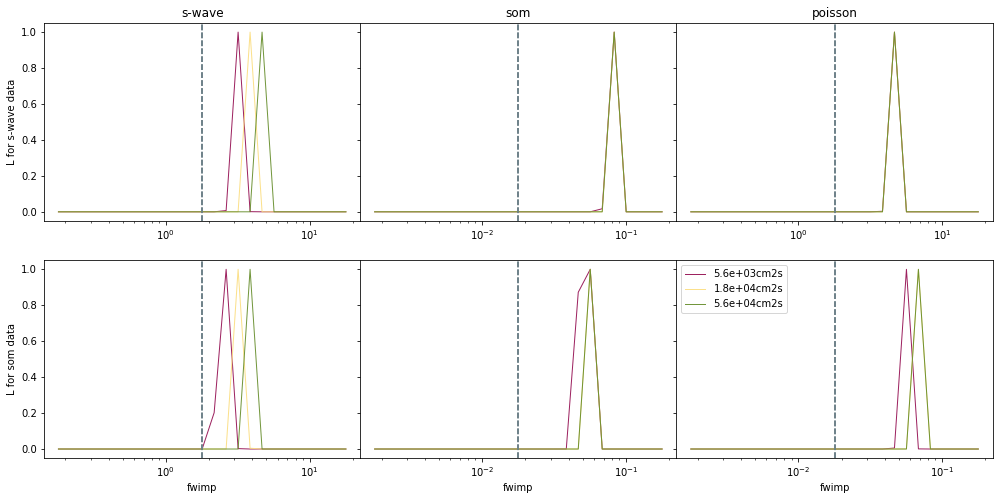

In [13]:
fig, axss = plt.subplots(ncols=3, nrows=2, figsize=(17, 8), sharey=True, gridspec_kw={'wspace': 0})
i = 0
lw = 5
zorder = 1

axs = axss[0]

for ax, s, lab in zip(axs, SS[0], ['s-wave L', 'som L', 'poisson L']):
    colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
    for expdat, expo in zip(s, exposure_search):
        if lab == 'som L':
            ax.plot(fwimps / 100, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', alpha=0.9, lw=1, color=next(colors))
            ax.axvline(p['fwimp']/100, ls='--', color='xkcd:steel gray')
#             ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
            print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)
        else:
            ax.plot(fwimps, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', alpha=0.9, lw=1, color=next(colors))
            ax.axvline(p['fwimp'], ls='--', color='xkcd:steel gray')
#             ax.plot(fwimps, expdat - expdat.min(), label=f'{expo:.2}cm2s')
            print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()])

    ax.set_xscale('log')
    
axs = axss[1]
p['fwimp'] /=100
for ax, s, lab in zip(axs, SS[1], ['s-wave L', 'som L', 'poisson L']):
    colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
    for expdat, expo in zip(s, exposure_search):
        if lab == 'som L' or lab == 'poisson L':
            ax.plot(fwimps / 100, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', alpha=0.9, lw=1, color=next(colors))
            ax.axvline(p['fwimp'], ls='--', color='xkcd:steel gray')
#             ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
            print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)
        else:
            ax.plot(fwimps, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', alpha=0.9, lw=1, color=next(colors))
            ax.axvline(p['fwimp']*100, ls='--', color='xkcd:steel gray')
#             ax.plot(fwimps, expdat - expdat.min(), label=f'{expo:.2}cm2s')
            print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()])

    ax.set_xscale('log')
    
for ax in axss[-1]:
    ax.set_xlabel('fwimp')
    
axss[0, 0].set_ylabel('L for s-wave data')
axss[1, 0].set_ylabel('L for som data')

axss[0, 0].set_title('s-wave')
axss[0, 1].set_title('som')
axss[0, 2].set_title('poisson')
    
axss.flatten()[-1].legend()
#     ax.set_yscale('log')
#     ax.set_ylim(bottom=0, top=10)
print(p['fwimp'])
fig.savefig('./output/llhds_97bgd.pdf')

Add:
- Float beg but fix bg to 0.97
- Float beg w/ same bg
- Generate w/ no DM signal and fit s/som/poi (null test)
- Add to overleaf
- 

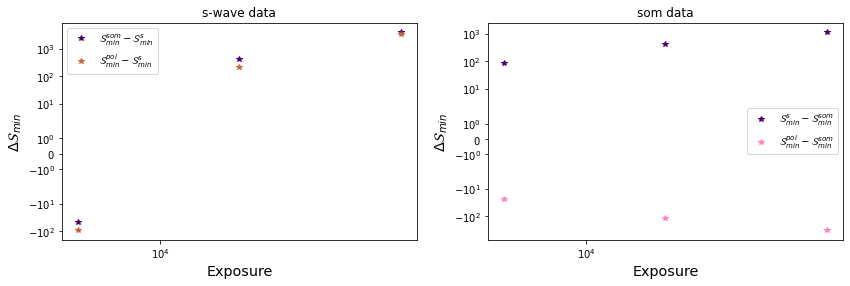

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(14,4))

ax = axs[0]
s_S, som_S, poisson_S = SS[0]
max_swave = np.amin(s_S, axis=-1)
max_som = np.amin(som_S, axis=-1)
max_poi = np.amin(poisson_S, axis=-1)
ax.plot(exposure_search, -max_swave + max_som, ls='', marker='*', color='xkcd:royal purple', label=r'$\mathcal{S}_{min}^{som} - \mathcal{S}_{min}^{s}$')
ax.plot(exposure_search, -max_swave + max_poi, ls='', marker='*', color='xkcd:terra cotta', label=r'$\mathcal{S}_{min}^{poi} - \mathcal{S}_{min}^{s}$')
# ax.plot(exposure_search, max_som - max_poi, ls='', marker='*', color='xkcd:pink', label=r'$\mathcal{S}_{min}^{som} - \mathcal{S}_{min}^{poi}$')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.set_ylabel(r'$\Delta\mathcal{S}_{min}$', fontsize='x-large')
ax.set_xlabel(r'Exposure', fontsize='x-large')
ax.legend()
 
ax = axs[1]
s_S, som_S, poisson_S = SS[1]
max_swave = np.amin(s_S, axis=-1)
max_som = np.amin(som_S, axis=-1)
max_poi = np.amin(poisson_S, axis=-1)
ax.plot(exposure_search, max_swave - max_som, ls='', marker='*', color='xkcd:royal purple', label=r'$\mathcal{S}_{min}^{s} - \mathcal{S}_{min}^{som}$')
# ax.plot(exposure_search, max_swave - max_poi, ls='', marker='*', color='xkcd:terra cotta', label=r'$\mathcal{S}_{min}^{s} - \mathcal{S}_{min}^{poi}$')
ax.plot(exposure_search, - max_som + max_poi, ls='', marker='*', color='xkcd:pink', label=r'$\mathcal{S}_{min}^{poi} - \mathcal{S}_{min}^{som}$')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.set_ylabel(r'$\Delta\mathcal{S}_{min}$', fontsize='x-large')
ax.set_xlabel(r'Exposure', fontsize='x-large')
ax.legend()

axs[0].set_title('s-wave data')
axs[1].set_title('som data')

fig.savefig('./output/deltaS_97bgd.pdf')

NameError: name 'mean' is not defined

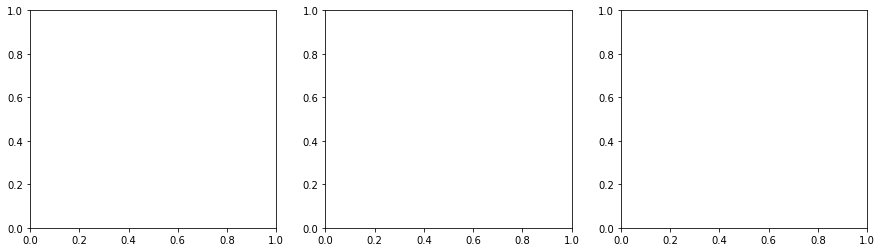

In [15]:
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
axs[0].plot(exposure_search, mean, label='mean', marker='o', ms=10)
axs[0].set_title('mean counts')
axs[1].plot(exposure_search, meanpc, label='P(C) mean', marker='o', ms=10)
axs[1].set_title('mean P(C)')
axs[2].plot(exposure_search, total, label='P(C) mean', marker='o', ms=10)
axs[2].set_title('total counts')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
# ax.set_ylim(bottom=0, top=)
ax.set_yscale('log')
ax.set_ylabel('Exposure [cm2 s]')
ax.set_xscale('log')
ax.set_xlabel('fwimp')
pc = ax.pcolormesh(fwimps, exposure_search, np.log10(s_S), cmap=cm.jet, shading='auto')
fig.colorbar(pc, label='S for s-wave');

In [ ]:
max_swave = np.amin(s_S, axis=-1)
max_som = np.amin(som_S, axis=-1)
max_poi = np.amin(poisson_S, axis=-1)